# Make a decent bar chart for feature importance

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from rfpimp import *


features = ['bedrooms','bathrooms','doorman','parking','laundry','walkup','ac','nofee','coop']
values = np.array([0.697091628, 0.181579262, 0.09046983, 0.0149105083, 0.00709949088, 0.00519591132, 0.00361618919, 3.71797701e-05, 0.0])

I = pd.DataFrame()
I['Feature'] = features
I['Importance'] = values
I = I.set_index('Feature')
I

,Importance
Feature,
bedrooms,0.697092
bathrooms,0.181579
doorman,0.090470
parking,0.014911
laundry,0.007099
walkup,0.005196
ac,0.003616
nofee,0.000037
coop,0.000000


In [2]:
features2 = ['bedrooms','bathrooms','doorman']
values2 = np.array([0.697091628, 0.181579262, 0.09046983])

I2 = pd.DataFrame()
I2['Feature'] = features2
I2['Importance'] = values2
I2 = I2.set_index('Feature')
I2

,Importance
Feature,
bedrooms,0.697092
bathrooms,0.181579
doorman,0.090470


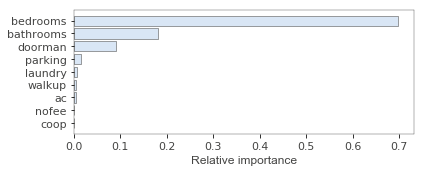

In [3]:
plot_importances(I, width=6)

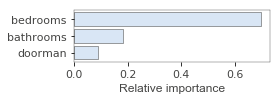

In [4]:
plot_importances(I2, width=4)

# Breast cancer importances

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd

cancer = load_breast_cancer()

X, y = cancer.data, cancer.target
df = pd.DataFrame(X, columns=cancer.feature_names)
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2) 

cl = RandomForestClassifier(n_estimators=100)
cl.fit(X_train, y_train)
cl.score(X_test, y_test)

0.9298245614035088

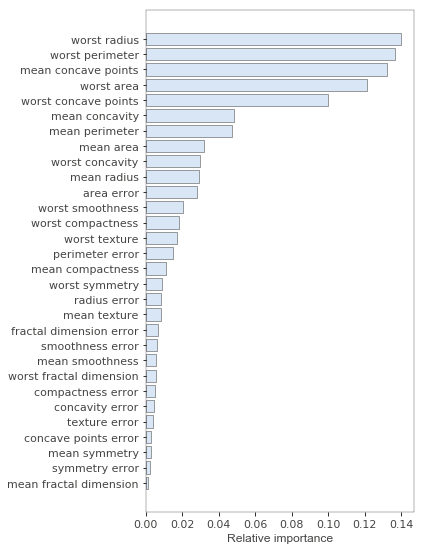

In [6]:
I = pd.DataFrame()

I['Feature'] = X_train.columns
I['Importance'] = cl.feature_importances_
I = I.sort_values('Importance', ascending=False)
I = I.set_index('Feature')
plot_importances(I, width=6)

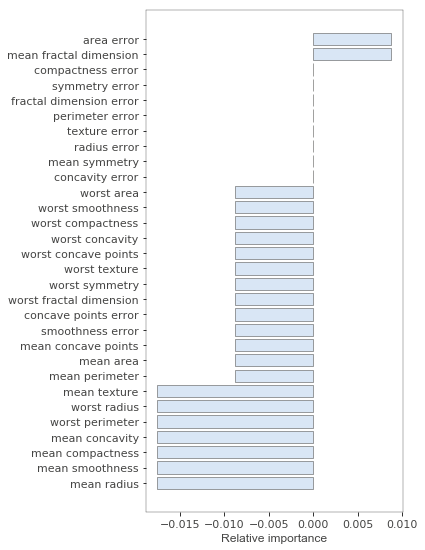

In [7]:
I = dropcol_importances(cl, X_train, y_train, X_test, y_test)
plot_importances(I, width=6)

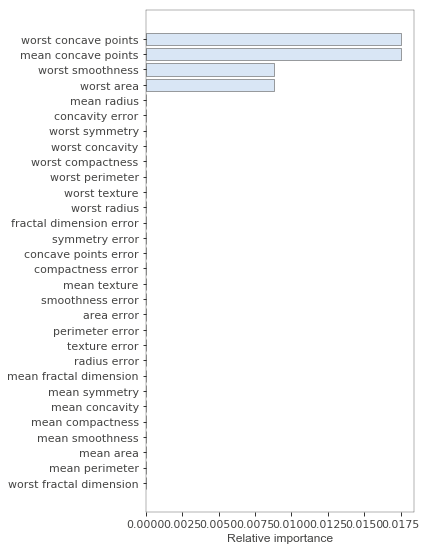

In [8]:
I = importances(cl, X_test, y_test)
plot_importances(I, width=6)

1.0


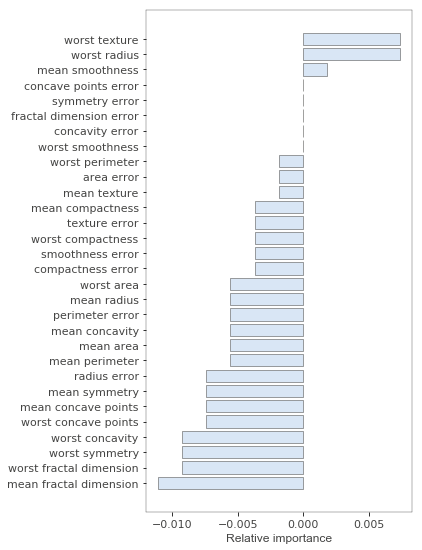

In [9]:
cancer = load_breast_cancer()

X, y = cancer.data, cancer.target
df = pd.DataFrame(X, columns=cancer.feature_names)
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.05) 

cl = RandomForestClassifier(n_estimators=100)
cl.fit(X_train, y_train)
print( cl.score(X_test, y_test) )
I = oob_dropcol_importances(cl, X_train, y_train)
plot_importances(I, width=6)